In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!nvidia-smi

Tue Apr 30 08:26:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.29                 Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0              24W /  88W |    417MiB /  6144MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# unzipping the data
# !unzip Eye.zip -d /

In [7]:
import pathlib
# Path to the dataset in your Google Drive
data_dir = 'Eye'

# If you need to extract a compressed file, you can do it like this:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = pathlib.Path(data_dir).with_suffix('')
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

# Now data_dir points to your dataset folder in Google Drive

In [8]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


2838


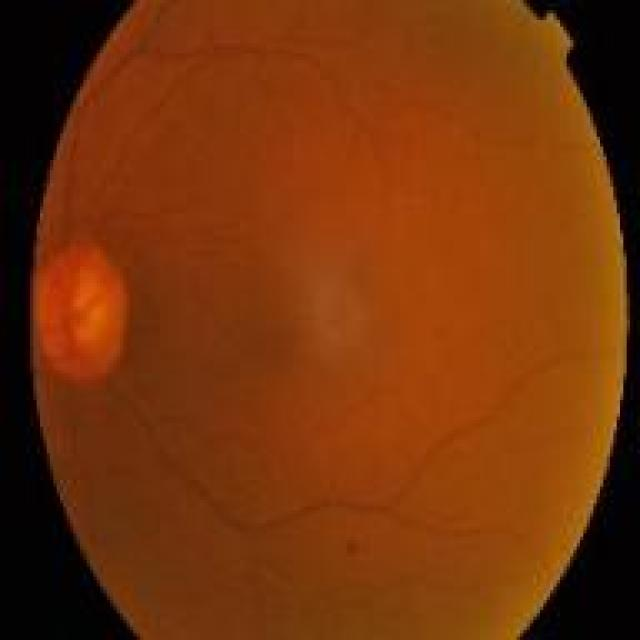

In [9]:
Mild = list(data_dir.glob('Mild/*'))
PIL.Image.open(str(Mild[0]))


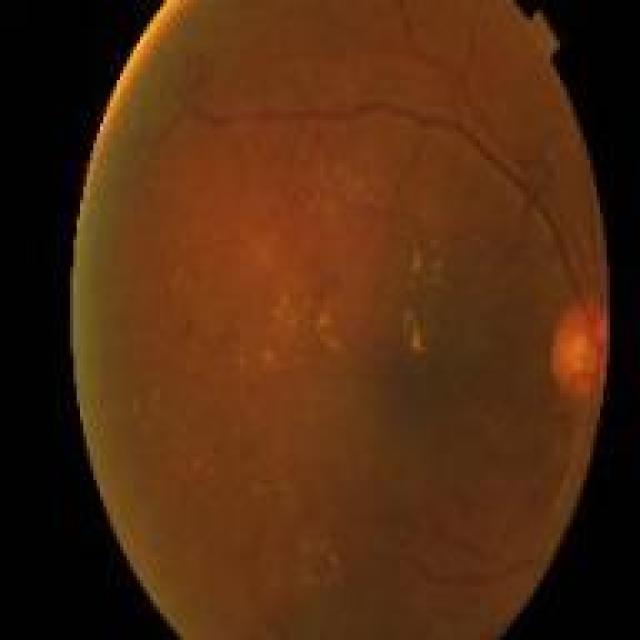

In [10]:
Moderate = list(data_dir.glob('Moderate/*'))
PIL.Image.open(str(Moderate[0]))

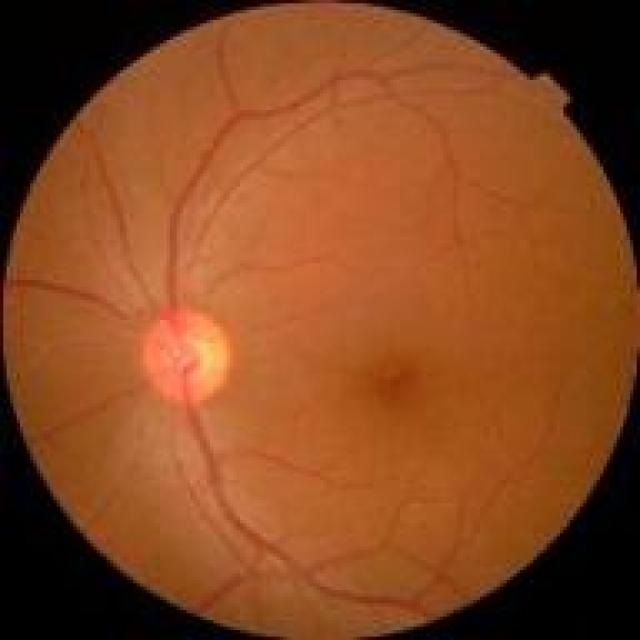

In [11]:
No_DR = list(data_dir.glob('No_DR/*'))
PIL.Image.open(str(No_DR[0]))

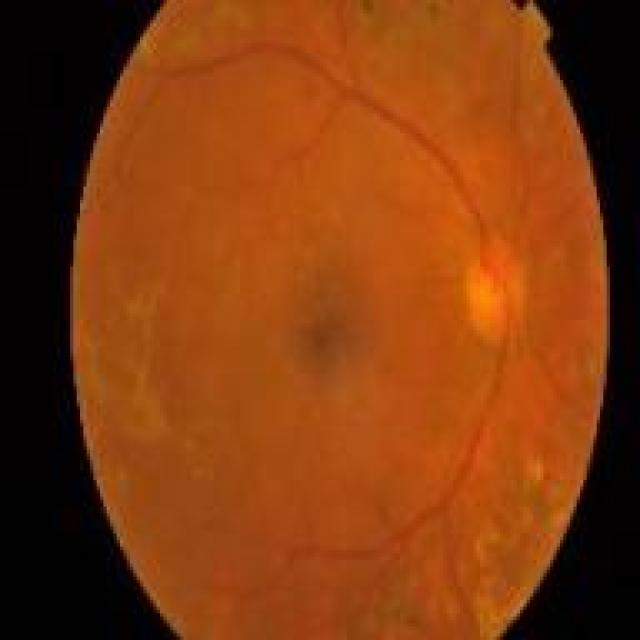

In [12]:
Proliferate_DR = list(data_dir.glob('Proliferate_DR/*'))
PIL.Image.open(str(Proliferate_DR[0]))

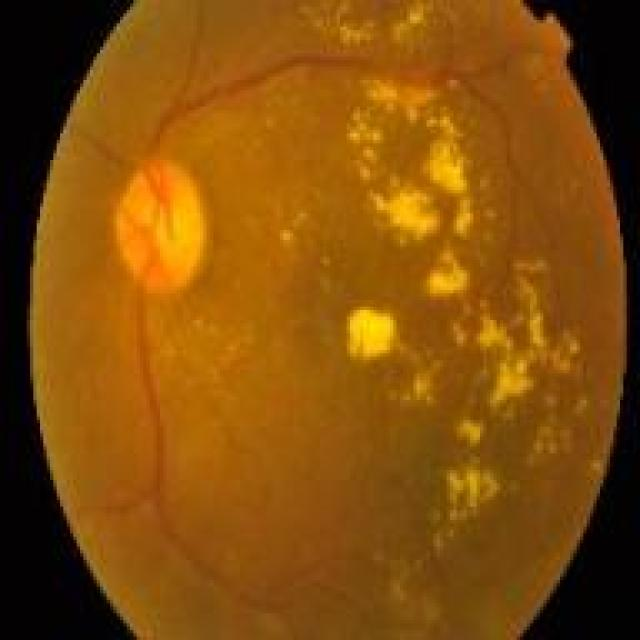

In [13]:
Severe = list(data_dir.glob('Severe/*'))
PIL.Image.open(str(Severe[0]))

In [14]:
batch_size = 32
img_height = 240
img_width = 240

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2838 files belonging to 5 classes.
Using 2271 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2838 files belonging to 5 classes.
Using 567 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


**First Nine Images from training dataset**

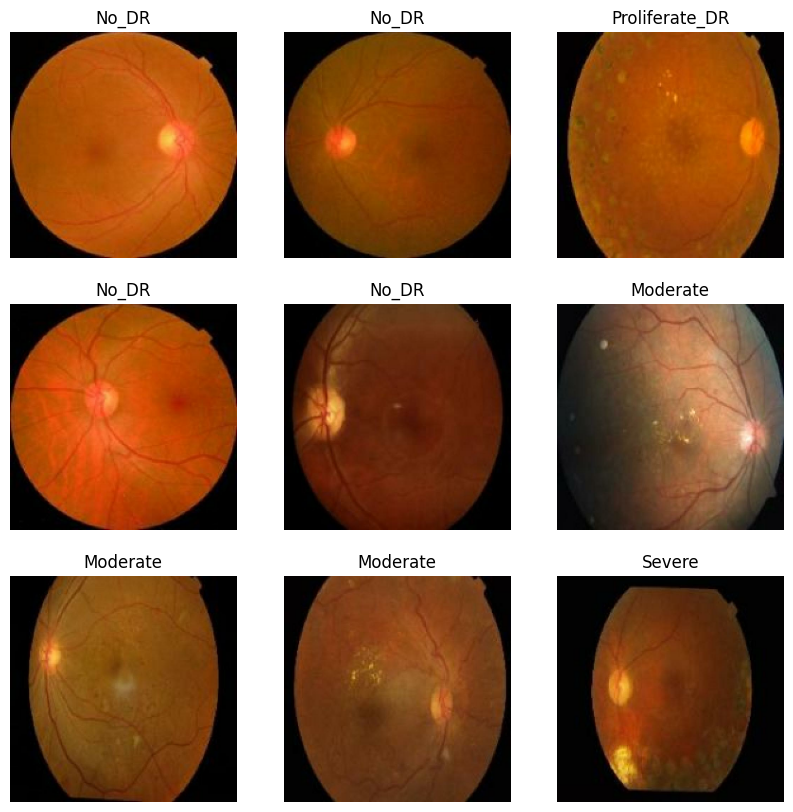

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

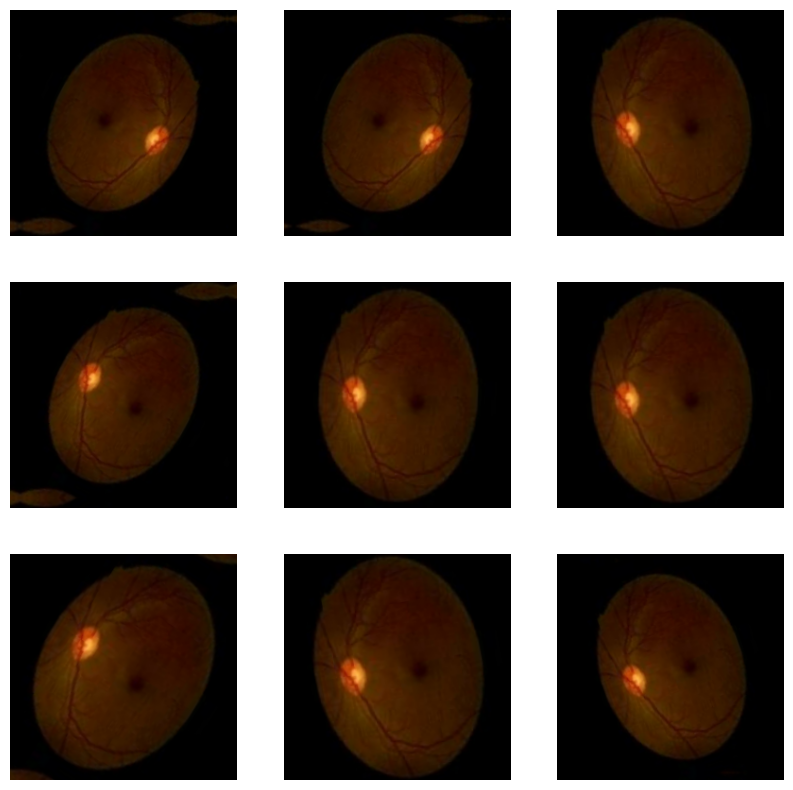

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                  

In [49]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\timmy\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 81s 899ms/step - loss: 1.1804 - accuracy: 0.5953 - val_loss: 0.9094 - val_accuracy: 0.6720
Epoch 2/20
71/71 [==============================] - 49s 683ms/step - loss: 0.8697 - accuracy: 0.7001 - val_loss: 0.8845 - val_accuracy: 0.6208
Epoch 3/20
71/71 [==============================] - 49s 684ms/step - loss: 0.8130 - accuracy: 0.7059 - val_loss: 0.8320 - val_accuracy: 0.6896
Epoch 4/20
71/71 [==============================] - 48s 680ms/step - loss: 0.8096 - accuracy: 0.7120 - val_loss: 0.8161 - val_accuracy: 0.6984
Epoch 5/20
71/71 [==============================] - 49s 685ms/step - loss: 0.7877 - accuracy: 0.7182 - val_loss: 0.8032 - val_accuracy: 0.7160
Epoch 6/20
71/71 [==============================] - 49s 685ms/step - loss: 0.7604 - accuracy: 0.7177 - val_loss: 0.7766 - val_accuracy: 0.7196
Epoch 7/20
71/71 [==============================] - 49s 684ms/step - loss: 0.7510 - accuracy: 0.7261 - val_loss: 0.8039 - val_accuracy: 0.7143
Epoch 8/20

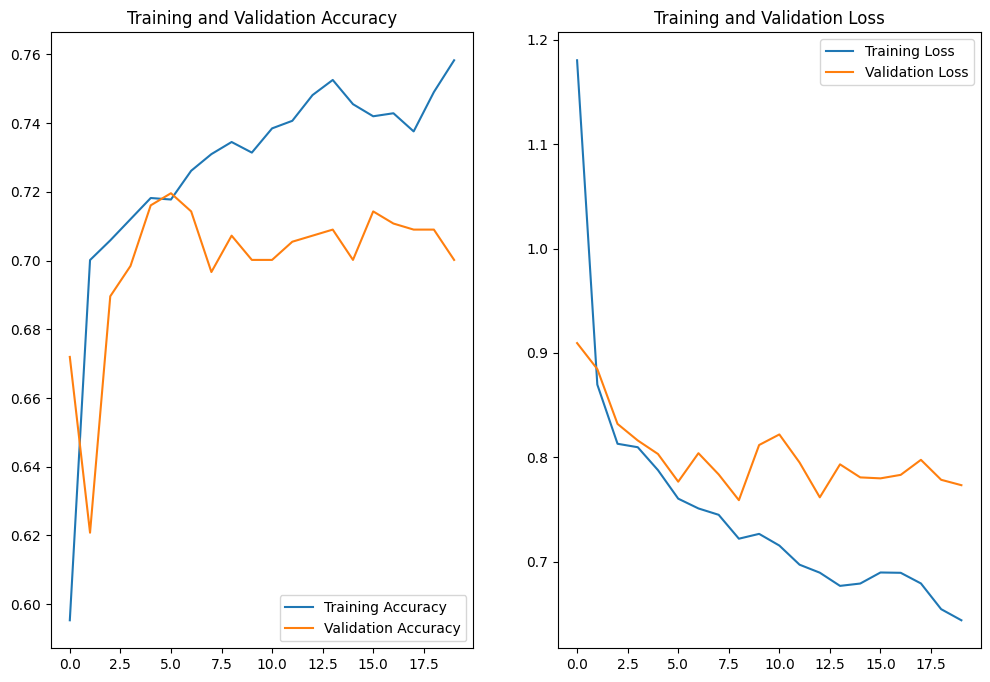

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer learning

In [54]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [55]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers so they are not updated during training
base_model.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Using softmax for multi-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,422,597
Trainable params: 164,613
Non-

In [57]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 [==============================] - 31s 339ms/step - loss: 0.9137 - accuracy: 0.6711 - val_loss: 0.8338 - val_accuracy: 0.6808
Epoch 2/20
71/71 [==============================] - 7s 101ms/step - loss: 0.8041 - accuracy: 0.7076 - val_loss: 0.7819 - val_accuracy: 0.7249
Epoch 3/20
71/71 [==============================] - 7s 99ms/step - loss: 0.7787 - accuracy: 0.7221 - val_loss: 0.7839 - val_accuracy: 0.7072
Epoch 4/20
71/71 [==============================] - 7s 98ms/step - loss: 0.7561 - accuracy: 0.7389 - val_loss: 0.7588 - val_accuracy: 0.7125
Epoch 5/20
71/71 [==============================] - 7s 98ms/step - loss: 0.7447 - accuracy: 0.7274 - val_loss: 0.7541 - val_accuracy: 0.7178
Epoch 6/20
71/71 [==============================] - 7s 102ms/step - loss: 0.7287 - accuracy: 0.7406 - val_loss: 0.7474 - val_accuracy: 0.7125
Epoch 7/20
71/71 [==============================] - 7s 99ms/step - loss: 0.7147 - accuracy: 0.7442 - val_loss: 0.7493 - val_accuracy: 0.7178
Epoch 8/2

In [58]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_____________________________________

In [59]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 [==============================] - 45s 499ms/step - loss: 1.5930 - accuracy: 0.5768 - val_loss: 0.9014 - val_accuracy: 0.6631
Epoch 2/20
71/71 [==============================] - 19s 272ms/step - loss: 0.9905 - accuracy: 0.6627 - val_loss: 0.7796 - val_accuracy: 0.6984
Epoch 3/20
71/71 [==============================] - 19s 271ms/step - loss: 0.8841 - accuracy: 0.6909 - val_loss: 0.7194 - val_accuracy: 0.7249
Epoch 4/20
71/71 [==============================] - 20s 276ms/step - loss: 0.7660 - accuracy: 0.7147 - val_loss: 0.6757 - val_accuracy: 0.7266
Epoch 5/20
71/71 [==============================] - 20s 282ms/step - loss: 0.7298 - accuracy: 0.7318 - val_loss: 0.6849 - val_accuracy: 0.7337
Epoch 6/20
71/71 [==============================] - 20s 285ms/step - loss: 0.7064 - accuracy: 0.7301 - val_loss: 0.6742 - val_accuracy: 0.7249
Epoch 7/20
71/71 [==============================] - 20s 286ms/step - loss: 0.6829 - accuracy: 0.7446 - val_loss: 0.6371 - val_accuracy: 0.7496

In [60]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 [==============================] - 16s 1us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7,169,349
Trainable params: 131,845
Non-

In [61]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 [==============================] - 37s 297ms/step - loss: 2.4476 - accuracy: 0.5447 - val_loss: 0.9493 - val_accuracy: 0.7090
Epoch 2/20
71/71 [==============================] - 13s 185ms/step - loss: 1.3509 - accuracy: 0.6178 - val_loss: 0.9991 - val_accuracy: 0.6720
Epoch 3/20
71/71 [==============================] - 13s 182ms/step - loss: 1.1413 - accuracy: 0.6358 - val_loss: 0.8280 - val_accuracy: 0.7019
Epoch 4/20
71/71 [==============================] - 13s 181ms/step - loss: 1.0264 - accuracy: 0.6596 - val_loss: 0.8203 - val_accuracy: 0.7019
Epoch 5/20
71/71 [==============================] - 13s 190ms/step - loss: 0.9301 - accuracy: 0.6781 - val_loss: 0.8616 - val_accuracy: 0.7125
Epoch 6/20
71/71 [==============================] - 13s 187ms/step - loss: 0.8863 - accuracy: 0.6904 - val_loss: 0.7946 - val_accuracy: 0.7055
Epoch 7/20
71/71 [==============================] - 13s 190ms/step - loss: 0.8669 - accuracy: 0.7023 - val_loss: 0.7997 - val_accuracy: 0.7072

In [62]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 [==============================] - 5s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4,214,184
Trainable params: 164,613
Non-t

In [63]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 [==============================] - 34s 263ms/step - loss: 0.8830 - accuracy: 0.6865 - val_loss: 0.7440 - val_accuracy: 0.7319
Epoch 2/20
71/71 [==============================] - 12s 168ms/step - loss: 0.6994 - accuracy: 0.7371 - val_loss: 0.6594 - val_accuracy: 0.7549
Epoch 3/20
71/71 [==============================] - 13s 185ms/step - loss: 0.6532 - accuracy: 0.7530 - val_loss: 0.6372 - val_accuracy: 0.7743
Epoch 4/20
71/71 [==============================] - 11s 157ms/step - loss: 0.6316 - accuracy: 0.7635 - val_loss: 0.6477 - val_accuracy: 0.7531
Epoch 5/20
71/71 [==============================] - 11s 156ms/step - loss: 0.6020 - accuracy: 0.7728 - val_loss: 0.6364 - val_accuracy: 0.7654
Epoch 6/20
71/71 [==============================] - 12s 162ms/step - loss: 0.5750 - accuracy: 0.7741 - val_loss: 0.6337 - val_accuracy: 0.7831
Epoch 7/20
71/71 [==============================] - 11s 155ms/step - loss: 0.5659 - accuracy: 0.7873 - val_loss: 0.6589 - val_accuracy: 0.7407

In [70]:
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

12683000/12683000 [==============================] - 6s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_7   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 960)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               123008    
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                       

In [71]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
71/71 [==============================] - 31s 340ms/step - loss: 0.9896 - accuracy: 0.6596 - val_loss: 0.7032 - val_accuracy: 0.7284
Epoch 2/20
71/71 [==============================] - 20s 281ms/step - loss: 0.7234 - accuracy: 0.7296 - val_loss: 0.6334 - val_accuracy: 0.7513
Epoch 3/20
71/71 [==============================] - 20s 286ms/step - loss: 0.6578 - accuracy: 0.7543 - val_loss: 0.6179 - val_accuracy: 0.7707
Epoch 4/20
71/71 [==============================] - 20s 279ms/step - loss: 0.6062 - accuracy: 0.7772 - val_loss: 0.5716 - val_accuracy: 0.7919
Epoch 5/20
71/71 [==============================] - 20s 283ms/step - loss: 0.6186 - accuracy: 0.7697 - val_loss: 0.6019 - val_accuracy: 0.7690
Epoch 6/20
71/71 [==============================] - 20s 278ms/step - loss: 0.5839 - accuracy: 0.7785 - val_loss: 0.5676 - val_accuracy: 0.7901
Epoch 7/20
71/71 [==============================] - 20s 283ms/step - loss: 0.5688 - accuracy: 0.7878 - val_loss: 0.5643 - val_accuracy: 0.7866

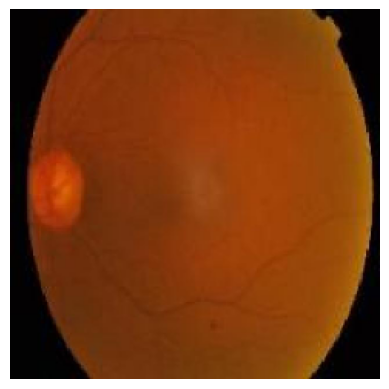

1/1 [==============================] - 6s 6s/step
This image most likely belongs to Mild with a 34.60 percent confidence.


In [73]:
# Path to the image in your Google Drive
eye_path = 'Eye/Mild/0024cdab0c1e_png_jpg.rf.be534a3f321f6a4dcbe72e0e7616f99c.jpg'

# Load the image
img = tf.keras.preprocessing.image.load_img(eye_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

# Print the image
plt.imshow(img)
plt.axis('off')  # Remove axes
plt.show()

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']  # Define your class names
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## Hyperparameter tuning with wandb

In [23]:
!pip install wandb

  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
    --------------------------------------- 0.0/2.2 MB 660.6 kB/s eta 0:00:04
    --------------------------------------- 0.0/2.2 MB 660.6 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.2 MB 383.3 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.2 MB 437.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.2 MB 437.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/2.2 MB 468.3 kB/s eta 0:00:05
   ---- ----------------------------------- 0.2/2.2 MB 573.4 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/2.2 MB 602.4 kB/s eta 0:00:04
   ---- ----------------------------------- 0.3/2.2 MB 524.0 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/2.2 MB 597.8 kB/s eta 0:00:04
   -------- --

In [26]:
!wandb login 6ff7d06b803cabf3b583a8b0a005370fd8081754

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\timmy\.netrc


In [27]:
import wandb

In [33]:
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [53]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(16, activation='relu'),
  Dense(num_classes, name="outputs")
])

config = {
  "data_augmentation": True,  # Set to True or False for data augmentation
  "dropout_rate": 0.2  # Dropout rate for regularization
}
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Initialize Wandb run
wandb.init(project="eye-classification", config=config)


In [54]:
num_classes

5

In [55]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[wandb.keras.WandbCallback()])

Epoch 1/10
 6/71 [=>............................] - ETA: 18s - loss: 1.4318 - accuracy: 0.5312

71/71 [==============================] - ETA: 0s - loss: 1.1098 - accuracy: 0.5755

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 24s 309ms/step - loss: 1.1098 - accuracy: 0.5755 - val_loss: 0.9339 - val_accuracy: 0.6473
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.9409 - accuracy: 0.6693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 22s 307ms/step - loss: 0.9409 - accuracy: 0.6693 - val_loss: 0.9007 - val_accuracy: 0.6825
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 22s 304ms/step - loss: 0.8929 - accuracy: 0.6821 - val_loss: 0.8634 - val_accuracy: 0.6949
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.7173

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 22s 312ms/step - loss: 0.8412 - accuracy: 0.7173 - val_loss: 0.8581 - val_accuracy: 0.7002
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.8299 - accuracy: 0.7182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.1s


71/71 [==============================] - 24s 335ms/step - loss: 0.8299 - accuracy: 0.7182 - val_loss: 0.8113 - val_accuracy: 0.7160
Epoch 6/10
71/71 [==============================] - 20s 279ms/step - loss: 0.7941 - accuracy: 0.7244 - val_loss: 0.8349 - val_accuracy: 0.7055
Epoch 7/10
71/71 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7226

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 21s 303ms/step - loss: 0.7865 - accuracy: 0.7226 - val_loss: 0.7907 - val_accuracy: 0.7160
Epoch 8/10
71/71 [==============================] - 19s 265ms/step - loss: 0.7649 - accuracy: 0.7358 - val_loss: 0.8238 - val_accuracy: 0.7090
Epoch 9/10
71/71 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.7221

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240430_013416-vd5no454/files/model-best)... Done. 0.0s


71/71 [==============================] - 22s 306ms/step - loss: 0.7740 - accuracy: 0.7221 - val_loss: 0.7738 - val_accuracy: 0.7178
Epoch 10/10
71/71 [==============================] - 19s 267ms/step - loss: 0.7634 - accuracy: 0.7248 - val_loss: 0.7752 - val_accuracy: 0.7196


In [56]:
# Finish logging
wandb.finish()

accuracy,▁▅▆▇▇█▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▆▆█▇█▇██
val_loss,█▇▅▅▃▄▂▃▁▁
accuracy,0.72479
best_epoch,8
best_val_loss,0.77378
epoch,9
loss,0.76337
val_accuracy,0.71958


## Sweeping

In [34]:
# Define Sweep Configuration
sweep_config = {
    'method': 'random',  # Specify the search method
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # Metric to optimize
    'parameters': {
        'data_augmentation': {
            'values': [True, False]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.5]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'filters': {
            'values': [[32, 64, 128], [64, 128, 256], [128, 256, 512]]
        },
        'dense_neurons': {
            'values': [64, 128, 256]
        },
        'epochs': {
            'values': [1, 2, 3, 5]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.1
        },
        'batch_size': {
            'values': [8, 16, 32, 64, 128]
        }
    }
}


In [35]:
# Initialize Sweep
sweep_id = wandb.sweep(sweep_config, project="eye-classification-project")

Create sweep with ID: koo9ya12
Sweep URL: https://wandb.ai/timmyafolami/eye-classification-project/sweeps/koo9ya12


In [39]:
# Function to create and compile the model
def create_model(config):
    num_classes = len(class_names)
    model = Sequential()
    
    if config.data_augmentation:
        model.add(data_augmentation)
    
    model.add(Rescaling(1./255))
    model.add(Conv2D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    
    # Add additional convolutional layers based on hyperparameters
    for i in range(config.num_layers):
        model.add(Conv2D(config.filters[i], 3, padding='same', activation='relu'))
    
    model.add(MaxPooling2D())
    model.add(Dropout(config.dropout_rate))
    model.add(Flatten())
    model.add(Dense(config.dense_neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model


In [43]:
# Define the training function
def train():
    default_config = {
        "data_augmentation": True,
        "dropout_rate": 0.5,
        "num_layers": 3,
        "filters": [32, 64, 128],
        "dense_neurons": 128,
        "epochs": 15,
        "learning_rate": 0.001,
        "batch_size": 64
    }

    # Initialize W&B with default configuration
    wandb.init(config=default_config)
    config = wandb.config

    # Create and compile the model
    model = create_model(config)

    # Fit the model
    model.fit(train_ds,
              epochs=10,
              validation_data=val_ds,
              callbacks=[wandb.keras.WandbCallback(save_model=False)])

In [ ]:
# Run the sweep
wandb.agent(sweep_id, function=train, count=30)